In [1]:
import pandas as pd
import tifffile as tff
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
import copy

from src.utils import get_cnt_from_df, mpp_extractor, visualize_ds
from src.calc import cnt_lateral_length, mb_surface_intensity, tb_pure_intensity

# Агрегация данных

In [2]:
annot_paths = glob('annotated_data/annotations/*.csv')
img_names = [path.split('/')[-1].split('.')[0] for path in annot_paths]
img_paths = ['annotated_data/tiff_imgs/' + name + '.tif' for name in img_names]
meta_paths = glob('annotated_data/meta/*.txt')
source_names = ['_'.join(img_name.split('_')[:-1]) for img_name in img_names]
meta_paths

['annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt']

In [3]:
meta_df = pd.DataFrame({'meta_path': meta_paths,
                        'join_key' : [path.split('/')[-1].split('.')[0] for path in meta_paths]
                       }
                      )
meta_df['mpp'] = None
meta_df

,meta_path,join_key,mpp
0,annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt,40PS25PE35PC_H0_5mkm_4,None


In [4]:
for idx, row in meta_df.iterrows():
    with open(row['meta_path']) as f:
        mpp = mpp_extractor(f)
    meta_df.loc[idx, 'mpp'] = mpp
meta_df

,meta_path,join_key,mpp
0,annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt,40PS25PE35PC_H0_5mkm_4,0.082


In [5]:
dfs = []
for i, annot_path in enumerate(annot_paths):
    df = pd.read_csv(annot_path)
    df['image_name'] = img_names[i]
    df['image_path'] = img_paths[i]
    df['source_name'] = source_names[i]
    dfs.append(df)
df = pd.concat(dfs)

In [6]:
df = df.join(meta_df.set_index(['join_key']), on='source_name')

In [7]:
df.head()

,,roi_id,name,x,y,image_name,image_path,source_name,meta_path,mpp
0,1,0,membrane,2.5,231.0,40PS25PE35PC_H0_5mkm_4_C003T020,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,40PS25PE35PC_H0_5mkm_4,annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt,0.082
1,2,0,membrane,31.0,222.0,40PS25PE35PC_H0_5mkm_4_C003T020,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,40PS25PE35PC_H0_5mkm_4,annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt,0.082
2,3,0,membrane,89.5,202.5,40PS25PE35PC_H0_5mkm_4_C003T020,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,40PS25PE35PC_H0_5mkm_4,annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt,0.082
3,4,0,membrane,125.0,183.0,40PS25PE35PC_H0_5mkm_4_C003T020,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,40PS25PE35PC_H0_5mkm_4,annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt,0.082
4,5,0,membrane,146.0,172.5,40PS25PE35PC_H0_5mkm_4_C003T020,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,40PS25PE35PC_H0_5mkm_4,annotated_data/meta/40PS25PE35PC_H0_5mkm_4.txt,0.082


# Формируем таблицу изображение <-> контуры
## контуры будем хранить так

In [8]:
d = {'membrane_rois': 
        {'membranes_cnts': [],
         'bg_cnts': [],
        },
     'tube_rois': []
    }

In [9]:
row_ds = []
for image_name in df['image_name'].unique():
    row_d = {}
    row_d['image_name'] = image_name
    img_slice = df.query('image_name == @image_name')
    row_d['image_path'] = img_slice.sample()['image_path'].item()
    row_d['mpp'] = img_slice.sample()['mpp'].item()
    
    cnts_d = copy.deepcopy(d)
    # membranes cnts
    temp_slice = img_slice.query('name == "membrane"')
    for _, rows in temp_slice.groupby('roi_id'):
        (cnts_d['membrane_rois']
               ['membranes_cnts']
               .append(
                       get_cnt_from_df(rows)
                      )
        )
        
    # bg_membranes cnts
    temp_slice = img_slice.query('name == "bg_membrane"')
    for _, rows in temp_slice.groupby('roi_id'):
        (cnts_d['membrane_rois']
               ['bg_cnts']
               .append(
                       get_cnt_from_df(rows)
                      )
        )
        
    # tube + bg_tube cnts
    tube_names = img_slice['name'].unique()
    tube_names = [name for name in tube_names if name.find('tube') != -1]
    tube_names = [name for name in tube_names if name.find('bg') == -1]
    bg_tube_names = ['bg_' + name for name in tube_names]
    for tn, bg_tn in zip(tube_names, bg_tube_names):
        (cnts_d['tube_rois']
               .append(
                       {
                        'tube' : get_cnt_from_df(img_slice.query('name == @tn')),
                        'bg_tube': get_cnt_from_df(img_slice.query('name == @bg_tn'))
                       }
                      )
        )
    row_d['cnts_d'] = cnts_d
    row_ds.append(row_d)

In [10]:
imgs_df = pd.DataFrame(row_ds)

In [11]:
imgs_df.head()

,image_name,image_path,mpp,cnts_d
0,40PS25PE35PC_H0_5mkm_4_C003T020,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,0.082,{'membrane_rois': {'membranes_cnts': [[[[ 2 2...
1,40PS25PE35PC_H0_5mkm_4_C003T030,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,0.082,{'membrane_rois': {'membranes_cnts': [[[[ 5 2...
2,40PS25PE35PC_H0_5mkm_4_C003T018,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,0.082,{'membrane_rois': {'membranes_cnts': [[[[ 2 2...
3,40PS25PE35PC_H0_5mkm_4_C003T017,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,0.082,{'membrane_rois': {'membranes_cnts': [[[[ 2 2...
4,40PS25PE35PC_H0_5mkm_4_C003T021,annotated_data/tiff_imgs/40PS25PE35PC_H0_5mkm_...,0.082,{'membrane_rois': {'membranes_cnts': [[[[ 2 2...


# Смотрим на данные, считаем радиусы

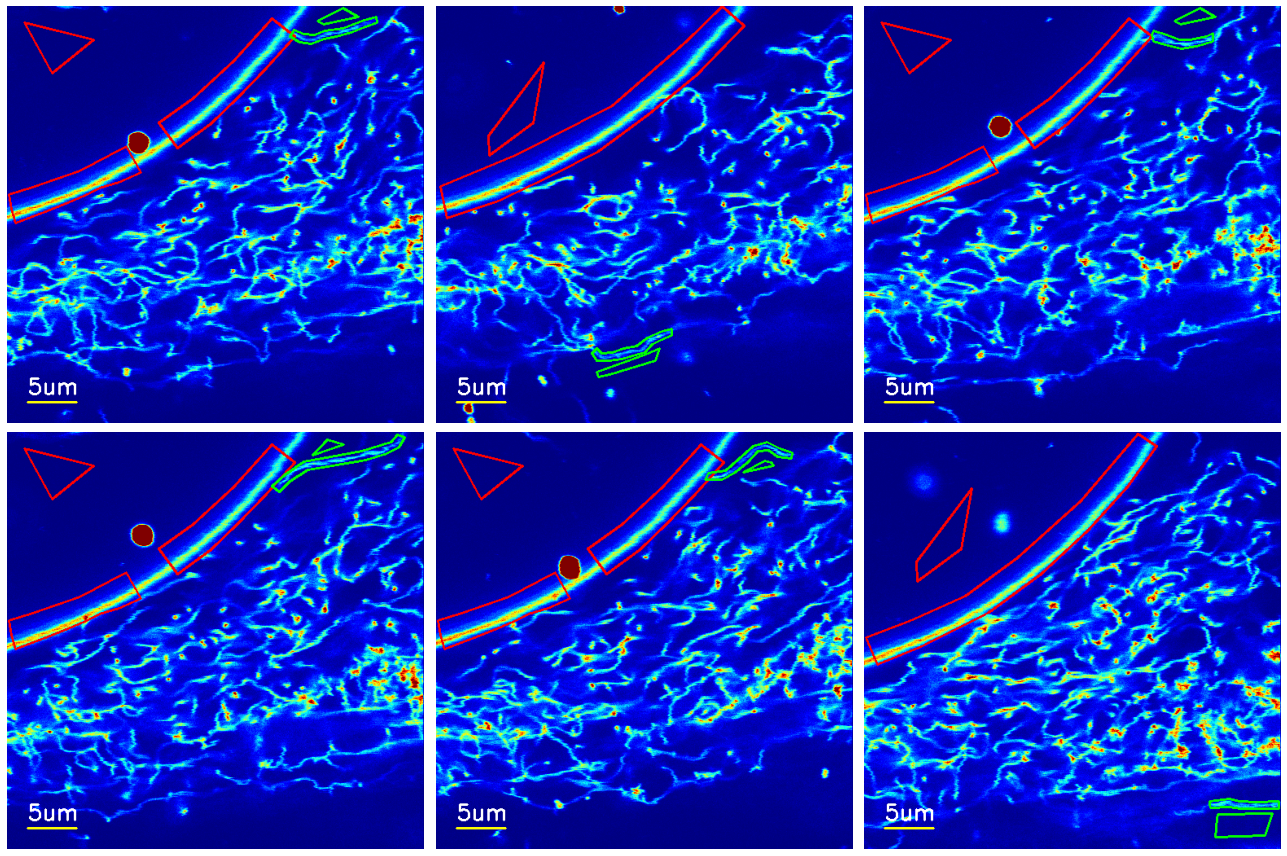

In [12]:
visualize_ds(imgs_df, 3, (18, 12))

$$ r = \frac{I_{t}}{2 \pi l_t \rho_m} ; \rho_m = \frac{I_m}{l_m \Delta z} $$

* $r$ - радиус трубки
* $I_{t}$ - интегральная интенсивность трубки
* $l_t$ - длина трубки
* $I_m$ - интегральная интенсивность участка мембраны
* $l_m$ - длина участка мембраны
* $\Delta z$ - толщина оптического среза

In [13]:
row_ds = []
for _, row in imgs_df.iterrows():
    cnts_d = row['cnts_d']
    mpp = row['mpp']
    image_name = row['image_name']
    mb_rois = cnts_d['membrane_rois']
    img = tff.imread(row['image_path'])
    rho_m = mb_surface_intensity(img, mb_rois['membranes_cnts'], mb_rois['bg_cnts'])
    
    tb_rois = cnts_d['tube_rois']
    for i, roi in enumerate(tb_rois):
        i_t = tb_pure_intensity(img, roi['tube'], roi['bg_tube'])
        l_t = cnt_lateral_length(roi['tube']) 
        r_um = i_t / (2 * np.pi * l_t * rho_m)
        r_nm = r_um * 1000
        
        d = {}
        d['image_name'] = image_name
        d['tube_id'] = i
        d['rho_m'] = rho_m
        d['i_t'] = i_t
        d['l_t'] = l_t
        d['r_nm'] = r_nm
        row_ds.append(d)

result = pd.DataFrame(row_ds)
result

,image_name,tube_id,rho_m,i_t,l_t,r_nm
0,40PS25PE35PC_H0_5mkm_4_C003T020,0,38539.794166,5.212535e+05,108.688651,19.805030
1,40PS25PE35PC_H0_5mkm_4_C003T030,0,38958.988193,5.527236e+05,104.059348,21.698984
2,40PS25PE35PC_H0_5mkm_4_C003T018,0,38533.236831,5.008641e+05,77.320677,26.755241
3,40PS25PE35PC_H0_5mkm_4_C003T017,0,38081.400936,1.051028e+06,172.204206,25.508081
4,40PS25PE35PC_H0_5mkm_4_C003T021,0,38719.362014,5.053762e+05,118.618326,17.512775
5,40PS25PE35PC_H0_5mkm_4_C003T003,0,35528.868685,5.316317e+05,84.625349,28.141626


In [14]:
result.describe()

,tube_id,rho_m,i_t,l_t,r_nm
count,6.0,6.000000,6.000000e+00,6.000000,6.000000
mean,0.0,38060.275138,6.104795e+05,110.919426,23.236956
std,0.0,1273.120329,2.166376e+05,33.726514,4.207180
min,0.0,35528.868685,5.008641e+05,77.320677,17.512775
25%,0.0,38194.359910,5.093456e+05,89.483849,20.278519
50%,0.0,38536.515499,5.264426e+05,106.374000,23.603533
75%,0.0,38674.470052,5.474507e+05,116.135907,26.443451
max,0.0,38958.988193,1.051028e+06,172.204206,28.141626
